In [133]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd

In [134]:
import io
df2 = pd.read_csv('Datas1.3.csv')
df2

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,result,Age,Genre,Né,Déjà,Pays,Ethnique,Parenté,Austime,Appli
1,1,1,1,1,0,0,1,1,0,0,6,26,0,0,0,United States',White-European,Self,0,0
2,1,1,0,1,0,0,0,1,0,1,5,24,1,0,0,Brazil,Latino,Self,1,0
3,1,1,0,1,1,0,1,1,1,1,8,27,1,1,0,Spain,Latino,Parent,1,1
4,1,1,0,1,0,0,1,1,0,1,6,35,0,0,0,United States',White-European,Self,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,0,1,0,1,1,0,1,1,1,1,7,25,0,0,0,Russia,White-European,Self,0,1
701,1,0,0,0,0,0,0,1,0,1,3,34,1,0,0,Mexico,Hispanic,Parent,0,0
702,1,0,1,1,1,0,1,1,0,1,7,24,0,0,0,Russia,?,?,0,1
703,1,0,0,1,1,0,1,0,1,1,6,35,1,0,0,Pakistan,South Asian',Self,0,0


In [135]:
#mat = np.loadtxt("datas1.2.csv", delimiter=",",dtype=str)
mat = np.array(df2)

1. Effectuer la régression de la variable autisme en fonction de toutes les autres.

$$
X^\top X \hat \alpha = X^\top y
$$

In [136]:
Age=mat[:,11]
for i in range(len(Age)):
    if (Age[i]=='?'):
        Age[i]='29'

In [137]:
names = mat[0]
X = np.array(mat[1:,:15], dtype=int)
y = np.array(mat[1:,18], dtype=int)
X = np.concatenate([X, np.ones((len(X), 1))], axis=-1)
X.shape

(704, 16)

In [138]:
a = np.linalg.solve(X.T@X, X.T@y)
a

array([ 0.12196816,  0.06821539,  0.07106671,  0.1554585 ,  0.06627364,
        0.06019186,  0.0170575 ,  0.08809841,  0.13248486,  0.10949802,
       -0.06837607,  0.00475199, -0.04283624,  0.1423172 ,  0.03160695,
       -0.1170402 ])

3\. Calculer les résidus de la régression
$$
\varepsilon = y - X\hat \alpha
$$

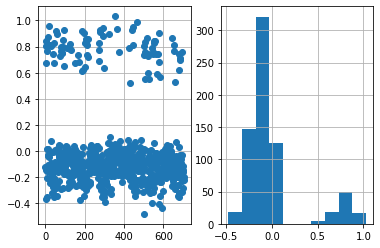

In [139]:
e = y-X@a
plt.subplot(1,2,1)
plt.plot(e,'o')
plt.grid()
plt.subplot(1,2,2)
plt.hist(e)
plt.grid()
plt.show()

4\. Calculer la somme des carrés totaux, la somme des carré des résidus et la somme des carrés de la partie expliquée du modèle

In [140]:
SCT = np.sum((y-np.mean(y))**2)
SCM = np.sum((X@a-np.mean(y))**2)
SCR = e.T@e
SCT, SCM, SCR

(79.23721590909093, 8.350092144809908, 70.887123764281)

5\. Quelle est la qualité de la régression ?

In [141]:
R2 = 1-SCR/SCT
R2

0.10538093809845639

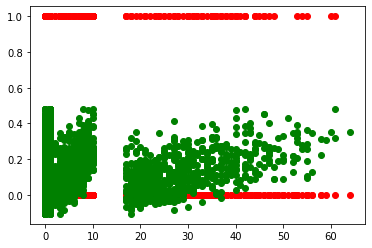

In [142]:
plt.plot(X,y,'or')
z=X@a
plt.plot(X,z,'og')
plt.show()

In [143]:
# Régression logistique

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Modèle de régression logistique
# https://fr.wikipedia.org/wiki/R%C3%A9gression_logistique
logreg = LogisticRegression(C=0.01, penalty="l2", dual=False).fit(X, y)

On pose $p = P(Y=1)$ la probabilité qu'une valeur de $y$ valle 1 (estimée par la moyenne de $y$)

La régression logistique se pose comme suit

$$
\ln\frac{p}{1-p} = \beta + \sum_{i=1}^{p} \alpha_px_p .
$$

On dit qu'on admet une relation linéaire entre $X$ et le *logit* de $y$.

On peut aussi le reformuler comme suit : 

$$
y = \frac{1}{1+\exp^{-z}}
$$

avec $z=\beta + \sum_{i=1}^{p} \alpha_px_p$.

On peut plot cette fonction :

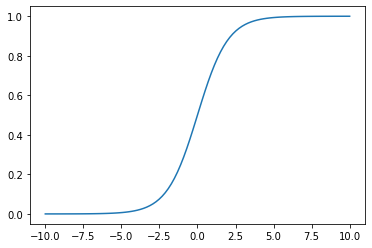

In [144]:
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)

On a bien la forme attendue pour une régression logistique.

La sélection de variables pour un modèle logistique se base non pas sur la variance ajoutée comme les algorithmes forward et backward mais sur la valeur absolue des associés à chaque variable

In [145]:
# Sélection de variables
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)

# On obtient une nouvelle matrice X_new sans les variables les moins importantes
X.shape, X_new.shape

((704, 16), (704, 7))

In [146]:
# Voici les variables que l'on a gardé
kept_vars = np.flip(np.argsort(np.abs(logreg.coef_)))[0,:7]  # On regarde les 7 variables avec le plus grand coefficient
names[kept_vars]

array(['result', 'A4', 'Né', 'Genre', 'A7', 'Age', 'A9'], dtype=object)

In [148]:
# Ici, on va évaluer le modèle. D'abord le score du modèle entraîné, puis par validation croisée à k-replis
# Le score obtenu est la précision (accuracy)
# https://en.wikipedia.org/wiki/Cross-validation_(statistics)
# https://en.wikipedia.org/wiki/Accuracy_and_precision

logreg = LogisticRegression(C=0.01, penalty="l2", dual=False)
logreg.score(X, y)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.